# Reconocer dígitos en lenguaje de señas

### <font color='B43F26'> Description </font>
***

<i><font color='8a8a8a'>The idea is to recognice digits presented in sign language, in an image set inside `sign_language_digits.zip`.</font></i><br>

<div class="alert alert-block alert-info">

## Setup
***

In [1]:
#Libreries Import.

import os
import numpy as np
from os import listdir
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras import initializers
#[FMaresca]
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from PIL import Image
import imageio

import matplotlib.pyplot as plt
import zipfile

## Unzip images

In [2]:
with zipfile.ZipFile('./input_images/sign_language_digits.zip', 'r') as zip_ref:
    zip_ref.extractall('./input_images/')

Some global settings.

In [3]:
img_size = 64    #Configure the image size with this parameter
num_class = 10   #Number of categories.
test_size = 0.2  #Configure the the % for testing dataset based on total images.

<div class="alert alert-block alert-info">
    
## Dataset Import
***

This dataset contains 1650 images with 10 diferent categories/labels. Each categoriy/label is a numerical digit (from 0 to 9) represented in sign language.
Each image has a 100x100 pixel resolutuon and each pixel is represented by 3 color values (RGB).

In [4]:
def get_img(data_path):
    #Getting image array from path:
    img = Image.open(data_path)
    img = img.resize((img_size, img_size))
    return np.asarray(img)

def get_dataset(dataset_path='./input_images/sign_language_digits'):
    labels = listdir(dataset_path) #Geting labels
    X = []
    Y = []
    for i, label in enumerate(labels):
        datas_path = dataset_path+'/'+label
        for data in listdir(datas_path):
            img = get_img(datas_path+'/'+data)
            X.append(img)
            Y.append(int(label))
    X = np.array(X).astype('float32')/255.
    Y = np.array(Y).astype('int')
    X, X_test, Y, Y_test = train_test_split(X, Y, test_size=test_size)
    return X, X_test, Y, Y_test


Training dataset and testing dataset split

In [5]:
X, X_test, Y, Y_test = get_dataset()

Let's show an image example:

Image label: 2


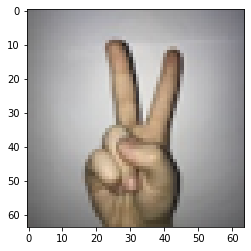

In [6]:
nro_image = 3

image = X[nro_image].reshape(1, img_size, img_size, 3)
plt.imshow(X[nro_image])
print("Image label: " + str(Y[nro_image]))

<div class="alert alert-block alert-info">
    
## Data Exploration
***

Before tuning is important to try to understand the information we have.

We have 4 arrays:

* `X` and `Y` are training set arrays —> data destinated for model tuning.
* The resulting model will be tested with the *test set*, `X_test` and `Y_test` arrays.

The images are 64x64x3 matrix (while `img_size=64`). Each RGB component takes values from 0 to 1.
The *labels* are integer arrays from 0 to 9 and correspond to the digit representation.

In [7]:
#Training dataset size.
X.shape

(1330, 64, 64, 3)

In [8]:
#Training labels count.
len(Y)

1330

In [9]:
#Show labels.
Y

array([6, 4, 5, ..., 2, 9, 7])

In [10]:
#Test dataset size.
X_test.shape

(333, 64, 64, 3)

In [11]:
#Show labels.
len(Y_test)

333

<div class="alert alert-block alert-info">
    
## Build the ML Model
***


In this case I decided to go for a neural network.

**Some questions you should ask before choosing the model**

**1) ¿Why you should use neural networks?**

*The neaural networks are good in learning image recognition and patterns. They are specially good working with big numbers of inputs (in this case all image pixels).*

**2) ¿How many features will have the nerual network?**

*It will have a feature count of: `img_size x img_size x 3` or `12288` in this configuration*

**3) ¿What is represented by a feature?**

*1 pixel and 1 color channel*

**4) The last neuron layer, ¿How many neurons will have? ¿Why?**

*It should have 10. This is because the result should be a number from 0 to 9 and the neural network will give the probability of each numerical option.*

**5) ¿Why using a convolutional network?**

*It's a method for reducing the image resolution. This generates that one feature correspons to a bigger field of activation in the input image. Also helps to speed up the tuning and training process.*


### Building the Network Layers 


**Conv2D** (https://keras.io/layers/convolutional/)

Convolucional Layer. Parameters:

* `filters`: Filters or channel number.
* `kernel_size`: Windows size that moves through the image. Example: (3,3), (5,5), (7,7).
* `input_shape`: Input dataset shape. Only needed for the first layer.


**Flatten** (https://keras.io/layers/core/)

Is use to connect convolutional layers to dense layers.


**Dense** (https://keras.io/layers/core/)

Neurons layer. Al inputs are connected to all neurons.

* `units`: Neurons number in the layer.
* `activation`: Activation function(https://keras.io/activations/). Usually used: 'softmax', 'relu', 'sigmoid'.


***Visual representation of a convolutional architecture:***

<img src="documentation/convolutional-and-pooling-layers.png" width="800">

In [12]:
model = Sequential()
#-Input_shape = (height, width, depth)
#- Applying regularization helps with: 
#  (1)Reduce overfitting effect. 
#  (2)Increment the model capacity to "generalice".
#------------------
#1st convolucional layer: learns 16 filters
model.add(Conv2D(16, (7, 7), strides=(2, 2), padding="valid",
                 kernel_initializer="he_normal", kernel_regularizer=l2(0.0005), input_shape=(64,64,3)))

#Then we add 2 more layers in which the model will learn 32 filters.
#------------------
model.add(Conv2D(32, (3, 3), padding="same",
                 kernel_initializer="he_normal", kernel_regularizer=l2(0.0005)))
model.add(Activation("relu"))
model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same",
                 kernel_initializer="he_normal", kernel_regularizer=l2(0.0005)))
model.add(Activation("relu"))
model.add(Dropout(0.25))

#Again, we add 2 more layers to learn 64 filters this time.
#------------------
model.add(Conv2D(64, (3, 3), padding="same",
                 kernel_initializer="he_normal", kernel_regularizer=l2(0.0005)))
model.add(Activation("relu"))
model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same",
                 kernel_initializer="he_normal", kernel_regularizer=l2(0.0005)))
model.add(Activation("relu"))
model.add(Dropout(0.25))

#For the last, 2 more layers incrementing filters up to 128.
#------------------
model.add(Conv2D(128, (3, 3), padding="same",
                 kernel_initializer="he_normal", kernel_regularizer=l2(0.0005)))
model.add(Activation("relu"))
model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same",
                 kernel_initializer="he_normal", kernel_regularizer=l2(0.0005)))
model.add(Activation("relu"))
model.add(Dropout(0.25))

model.add(Flatten())
#1st fully connected layer
#------------------
model.add(Dense(512, kernel_initializer="he_normal"))
model.add(Activation("relu"))
model.add(Dropout(0.5))

#2nd fully connected layer (Output)
#------------------
model.add(Dense(10, activation='softmax'))


### Model Compile

* `Loss function` —> Measures the model training error. The objective is to minimize this function.
* `Optimizer` —> The method used to update the model in order to minimize the loss function.
* `Metrics` —> The monitor metric will be the model accuuracy.

In [13]:
optim = Adam(learning_rate = 0.0005)
model.compile(optimizer = optim,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [14]:
#Let's show the network summary.
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 29, 29, 16)        2368      
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 activation (Activation)     (None, 29, 29, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 15, 15, 32)        0         
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 64)        1

<div class="alert alert-block alert-info">
 
## Model Tuning
***
    

**¿What's `overfitting`? ¿Why should be avoided?**

*Is the result of adjusting too much the model to the training dataset. It should be avoided because the resulting model will result "strongly connected" to the training dataset, which will lead to bad performance with new (and unknown) data.*


In [15]:
#Epochs and batch_size can be modified to obtain a better result.
history = model.fit(X, Y, validation_data=(X_test, Y_test), epochs=35, batch_size=40)

Epoch 1/35
34/34 [==============================] - 5s 129ms/step - loss: 2.8377 - accuracy: 0.1391 - val_loss: 2.7470 - val_accuracy: 0.1171
Epoch 2/35
34/34 [==============================] - 4s 114ms/step - loss: 2.7349 - accuracy: 0.1271 - val_loss: 2.6964 - val_accuracy: 0.2973
Epoch 3/35
34/34 [==============================] - 5s 138ms/step - loss: 2.5006 - accuracy: 0.2774 - val_loss: 2.0258 - val_accuracy: 0.4354
Epoch 4/35
34/34 [==============================] - 5s 134ms/step - loss: 2.0884 - accuracy: 0.4368 - val_loss: 1.5058 - val_accuracy: 0.6787
Epoch 5/35
34/34 [==============================] - 4s 108ms/step - loss: 1.5735 - accuracy: 0.6135 - val_loss: 1.1802 - val_accuracy: 0.7508
Epoch 6/35
34/34 [==============================] - 4s 109ms/step - loss: 1.2977 - accuracy: 0.7113 - val_loss: 1.0726 - val_accuracy: 0.8078
Epoch 7/35
34/34 [==============================] - 4s 122ms/step - loss: 1.0770 - accuracy: 0.7940 - val_loss: 0.8677 - val_accuracy: 0.8679
Epoch 

<div class="alert alert-block alert-info">
 
## Model Validation
***


Model evaluation and graph results.

In [16]:
train_loss, train_acc = model.evaluate(X, Y)
test_loss, test_acc = model.evaluate(X_test, Y_test)

print('\nTrain accuracy:', train_acc)
print('\nTest accuracy:', test_acc)

11/11 [==============================] - 0s 13ms/step - loss: 0.5779 - accuracy: 0.9520

Train accuracy: 1.0

Test accuracy: 0.9519519805908203


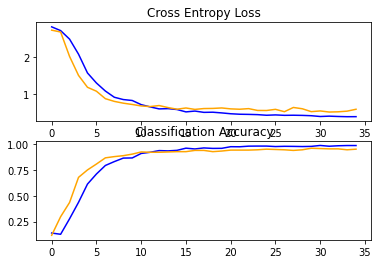

In [17]:
#Blue color: Training.
#Orange color: Testing.

from matplotlib import pyplot

#Loss plot
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')

#Accuracy plot
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

pyplot.show()

<div class="alert alert-block alert-info">

## Running Some Predictions
***


In [18]:
predictions = model.predict(X_test)

We can see what predicts the model for th 8th image:

In [29]:
predictions[8]

array([1.8385936e-10, 2.3660582e-09, 1.2768751e-07, 1.5558754e-08,
       1.1206546e-09, 3.6391462e-15, 1.5493058e-10, 9.9989045e-01,
       1.0939575e-04, 2.1600530e-12], dtype=float32)

*As it was already mentioned, the array represents the probability of reaching each possible value(from 0 to 9) for the selected image. In this case the second value (or label 1) is the most probable option.*

The assumption can be validated in the following two ways:

In [30]:
np.argmax(predictions[8])

7

In [31]:
Y_test[8]

7

Also we can show the test image:

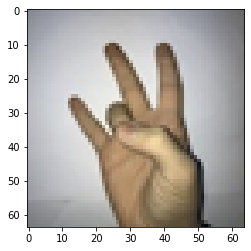

In [32]:
nro_image = 8

image = X_test[nro_image].reshape(1, img_size, img_size, 3)
plt.imshow(X_test[nro_image])